# Analysis of Strategic Turn-Based Adversarial Games Based on Reinforcement Learning:
## A Case Study of TicTacToe, Nim, and Connect Four

**We express our gratitude to the professors and teaching assistants of the CSC_5IA03_TA Reinforcement Learning course for their code contributions to Tic-Tac-Toe, Nim, and Connect Four these 3 environments.**

In [2]:
import numpy as np
from model import TicTacToe, Nim, ConnectFour
from agent import Agent, OnlineEvaluation, OnlineControl
from dynamic import PolicyEvaluation, PolicyIteration
from scipy import sparse

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

## Explain the environments

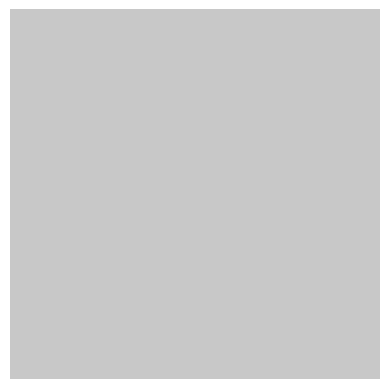

In [ ]:
game = TicTacToe()
agent = Agent(game)
stop, states, rewards = agent.get_episode()

# initial state and the animation of the game
game.display(states=states)

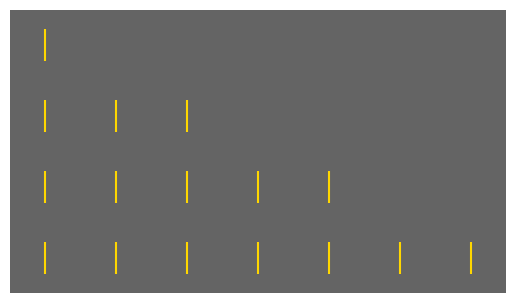

In [ ]:
game = Nim()
agent = Agent(game)
stop, states, rewards = agent.get_episode()

# initial state and the animation of the game
game.display(states=states)

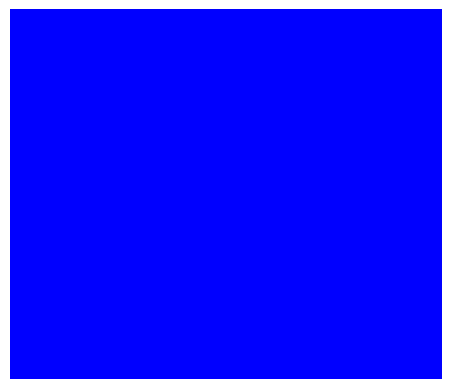

In [ ]:
game = ConnectFour()
agent = Agent(game)
stop, states, rewards = agent.get_episode()

# initial state and the animation of the game
game.display(states=states)

## Random Adversarial strategy

### Random player strategy

In [ ]:
game = TicTacToe(adversary_policy='random')
agent = Agent(game, policy="random")
gains = agent.get_gains(n_runs=1000)
np.mean(gains)

0.299

In [ ]:
game = Nim(adversary_policy='random')
agent = Agent(game, policy="random")
gains = agent.get_gains(n_runs=1000)
np.mean(gains)

-0.018

In [ ]:
game = ConnectFour(adversary_policy='random')
agent = Agent(game, policy="random")
gains = agent.get_gains(n_runs=1000)
np.mean(gains)

0.095

### Policy Iteration

In [ ]:
game = TicTacToe(adversary_policy='random')
algo = PolicyIteration(game)
policy = algo.get_optimal_policy()
agent_optimal = Agent(game, policy)
gains_optimal = agent_optimal.get_gains(n_runs=1000)
np.mean(gains_optimal)

0.995

In [ ]:
game = Nim(adversary_policy='random')
algo = PolicyIteration(game)
policy = algo.get_optimal_policy()
agent_optimal = Agent(game, policy)
gains_optimal = agent_optimal.get_gains(n_runs=1000)
np.mean(gains_optimal)

1.0

In [ ]:
try:
    game = ConnectFour(adversary_policy='random')
    algo = PolicyIteration(game)
    policy = algo.get_optimal_policy()
    agent_optimal = Agent(game, policy)
    gains_optimal = agent_optimal.get_gains(n_runs=1000)
    np.mean(gains_optimal)
except:
    print('ValueError: Not applicable. The state space is too large.')

ValueError: Not applicable. The state space is too large.


### Value Iteration

In [ ]:

class ValueIteration(PolicyEvaluation):
    """Value iteration.

    Parameters
    ----------
    model: object of class Environment
        The model.
    player: int
        Player for games (1 or -1, default = default player of the game).
    gamma: float
        Discount factor (between 0 and 1).
    n_iter: int
        Maximum number of value iterations.
    """

    def __init__(self, model, player=None, gamma=1, n_iter=100):
        agent = Agent(model, player=player)
        policy = agent.policy
        player = agent.player
        super(ValueIteration, self).__init__(model, policy, player, gamma)
        self.n_iter = n_iter

    def get_optimal_policy(self):
        """Get the optimal policy by iteration of Bellman's optimality equation."""
        transitions = self.transitions
        # Bellman's optimality equation
        values = np.zeros(self.n_states)
        for t in range(self.n_iter):
            next_values = self.rewards + self.gamma * values
            action_value = {action: transition.dot(next_values) for action, transition in self.transitions.items()}
            values = np.zeros(self.n_states)
            for i, state in enumerate(self.states):
                if not self.model.is_terminal(state):
                    actions = self.get_actions(state)
                    if self.player == 1:
                        values[i] = max([action_value[action][i] for action in actions])
                    else:
                        values[i] = min([action_value[action][i] for action in actions])
        self.values = values
        policy = self.get_policy()
        return policy

    def get_perfect_players(self):
        """Get perfect players for games, with the best response of the adversary."""
        if not self.model.is_game():
            raise ValueError("This method applies to games only.")
        # get transitions for each player
        actions = self.model.get_all_actions()
        transitions = {action: sparse.lil_matrix((self.n_states, self.n_states)) for action in actions}
        for i, state in enumerate(self.states):
            actions = self.model.get_available_actions(state)
            for action in actions:
                next_state = self.model.get_next_state(state, action)
                j = self.get_state_id(next_state)
                transitions[action][i, j] = 1
        transitions = {action: sparse.csr_matrix(transition) for action, transition in transitions.items()}
        self.transitions = transitions
        # Bellman's optimality equation
        values = np.zeros(self.n_states)
        for t in range(self.n_iter):
            next_values = self.rewards + self.gamma * values
            action_value = {action: transition.dot(next_values) for action, transition in transitions.items()}
            values = np.zeros(self.n_states)
            for i, state in enumerate(self.states):
                if not self.model.is_terminal(state):
                    player, _ = state
                    actions = self.model.get_available_actions(state)
                    # update values
                    if player == 1:
                        values[i] = max([action_value[action][i] for action in actions])
                    else:
                        values[i] = min([action_value[action][i] for action in actions])
        self.values = values
        # policies
        policy = self.get_policy(self.player)
        adversary_policy = self.get_policy(-self.player)
        return policy, adversary_policy


In [ ]:
game = TicTacToe(adversary_policy='random')
algo = ValueIteration(game)
policy = algo.get_optimal_policy()
agent_optimal = Agent(game, policy)
gains_optimal = agent_optimal.get_gains(n_runs=1000)
np.mean(gains_optimal)

0.994

In [ ]:
game = Nim(adversary_policy='random')
algo = ValueIteration(game)
policy = algo.get_optimal_policy()
agent_optimal = Agent(game, policy)
gains_optimal = agent_optimal.get_gains(n_runs=1000)
np.mean(gains_optimal)

1.0

In [ ]:
try:
    game = ConnectFour(adversary_policy='random')
    algo = ValueIteration(game)
    policy = algo.get_optimal_policy()
    agent_optimal = Agent(game, policy)
    gains_optimal = agent_optimal.get_gains(n_runs=1000)
    np.mean(gains_optimal)
except:
    print('ValueError: Not applicable. The state space is too large.')

ValueError: Not applicable. The state space is too large.


### Monte Carlo Learning

In [3]:
class MCLearning(OnlineEvaluation):
    """Online evaluation by Monte-Carlo."""

    def update_values(self, state=None, horizon=100):
        """Update the values from one episode."""
        stop, states, rewards = self.get_episode(state=state, horizon=horizon)
        # remove last state
        states.pop()
        gain = 0
        # backward update
        for state, reward in zip(reversed(states), reversed(rewards)):
            self.add_state(state)
            code = self.model.encode(state)
            self.count[code] += 1
            gain = reward + self.gamma * gain
            diff = gain - self.value[code]
            count = self.count[code]
            self.value[code] += diff / count


In [10]:
Game = TicTacToe
game = Game(adversary_policy='random')

# Monte-Carlo learning
algo = MCLearning(game, policy='random')
n_episodes = 10000
for t in tqdm(range(n_episodes)):
    algo.update_values()

# gain after learning
policy = algo.get_policy()
agent = Agent(game, policy)
gains = agent.get_gains(n_runs=1000)
print("Gain after learning", np.mean(gains))

100%|██████████| 10000/10000 [00:12<00:00, 788.67it/s]


Gain after learning 0.953


In [11]:
Game = Nim
game = Game(adversary_policy='random')

# Monte-Carlo learning
algo = MCLearning(game, policy='random')
n_episodes = 10000
for t in tqdm(range(n_episodes)):
    algo.update_values()

# gain after learning
policy = algo.get_policy()
agent = Agent(game, policy)
gains = agent.get_gains(n_runs=1000)
print("Gain after learning", np.mean(gains))

100%|██████████| 10000/10000 [00:09<00:00, 1077.56it/s]


Gain after learning 0.816


In [33]:
Game = ConnectFour
game = Game(adversary_policy='random')

# Monte-Carlo learning
algo = MCLearning(game, policy='random')
n_episodes = 10000
for t in tqdm(range(n_episodes)):
    algo.update_values()

# gain after learning
policy = algo.get_policy()
agent = Agent(game, policy)
gains = agent.get_gains(n_runs=1000)
print("Gain after learning", np.mean(gains))

100%|██████████| 10000/10000 [08:08<00:00, 20.49it/s]


Gain after learning 0.848


### Temporal Difference Learning

In [12]:
class TDLearning(OnlineEvaluation):
    """Online evaluation by TD learning."""

    def update_values(self, state=None, horizon=100):
        """Update values online from one episode."""
        self.model.reset(state)
        for t in range(horizon):
            state = self.model.state
            action = self.get_action(state)
            reward, stop = self.model.step(action)
            if stop:
                break
            next_state = self.model.state
            code = self.model.encode(state)
            next_code = self.model.encode(next_state)
            self.add_state(state)
            self.add_state(next_state)
            self.count[code] += 1
            self.count[next_code] += 1
            diff = reward + self.gamma * self.value[next_code] - self.value[code]
            count = self.count[code]
            self.value[code] += diff / count

In [28]:
Game = TicTacToe
game = Game(adversary_policy='random')

# TD learning
algo = TDLearning(game, policy='random')
n_episodes = 10000
for t in tqdm(range(n_episodes)):
    algo.update_values()

# gain after learning
policy = algo.get_policy()
agent = Agent(game, policy)
gains = agent.get_gains(n_runs=1000)
print("Gain after learning", np.mean(gains))

100%|██████████| 10000/10000 [00:13<00:00, 740.43it/s]


Gain after learning 0.663


In [29]:
Game = Nim
game = Game(adversary_policy='random')

# TD learning
algo = TDLearning(game, policy='random')
n_episodes = 10000
for t in tqdm(range(n_episodes)):
    algo.update_values()

# gain after learning
policy = algo.get_policy()
agent = Agent(game, policy)
gains = agent.get_gains(n_runs=1000)
print("Gain after learning", np.mean(gains))

100%|██████████| 10000/10000 [00:07<00:00, 1273.82it/s]


Gain after learning 0.18


In [34]:
Game = ConnectFour
game = Game(adversary_policy='random')

# TD learning
algo = TDLearning(game, policy='random')
n_episodes = 10000
for t in tqdm(range(n_episodes)):
    algo.update_values()

# gain after learning
policy = algo.get_policy()
agent = Agent(game, policy)
gains = agent.get_gains(n_runs=1000)
print("Gain after learning", np.mean(gains))

100%|██████████| 10000/10000 [07:42<00:00, 21.64it/s]


Gain after learning 0.654


### SARSA

In [16]:
class SARSA(OnlineControl):
    """Online control by SARSA."""

    def update_values(self, state=None, horizon=100, epsilon=0.5):
        """Learn the action-value function online."""
        self.model.reset(state)
        state = self.model.state
        if not self.model.is_terminal(state):
            action = self.randomize_best_action(state, epsilon=epsilon)
            for t in range(horizon):
                code = self.model.encode(state)
                self.action_count[code][action] += 1
                reward, stop = self.model.step(action)
                if stop:
                    gain = reward
                else:
                    next_state = self.model.state
                    next_code = self.model.encode(next_state)
                    next_action = self.randomize_best_action(next_state, epsilon=epsilon)
                    gain = reward + self.gamma * self.action_value[next_code][next_action]
                diff = gain - self.action_value[code][action]
                count = self.action_count[code][action]
                self.action_value[code][action] += diff / count
                if stop:
                    break
                state = next_state
                action = next_action

In [17]:
Game = TicTacToe
Control = SARSA
game = Game(adversary_policy='random')
algo = Control(game)

n_games = 10000
for i in tqdm(range(n_games)):
    algo.update_values(epsilon=0.1)

policy = algo.get_policy()
agent = Agent(game, policy)
gains = agent.get_gains(n_runs=1000)
print("Gain after learning", np.mean(gains))

100%|██████████| 10000/10000 [00:11<00:00, 850.05it/s]


Gain after learning 0.968


In [30]:
Game = Nim
Control = SARSA
game = Game(adversary_policy='random')
algo = Control(game)

n_games = 10000
for i in tqdm(range(n_games)):
    algo.update_values(epsilon=0.1)

policy = algo.get_policy()
agent = Agent(game, policy)
gains = agent.get_gains(n_runs=1000)
print("Gain after learning", np.mean(gains))

100%|██████████| 10000/10000 [00:09<00:00, 1081.54it/s]


Gain after learning 0.934


In [35]:
Game = ConnectFour
Control = SARSA
game = Game(adversary_policy='random')
algo = Control(game)

n_games = 10000
for i in tqdm(range(n_games)):
    algo.update_values(epsilon=0.1)

policy = algo.get_policy()
agent = Agent(game, policy)
gains = agent.get_gains(n_runs=1000)
print("Gain after learning", np.mean(gains))

100%|██████████| 10000/10000 [07:43<00:00, 21.60it/s]


Gain after learning 0.598


### Q Learning

In [20]:
class QLearning(OnlineControl):
    """Online control by Q-learning."""

    def update_values(self, state=None, horizon=100, epsilon=0.5):
        """Learn the action-value function online."""
        self.model.reset(state)
        state = self.model.state
        if not self.model.is_terminal(state):
            for t in range(horizon):
                code = self.model.encode(state)
                action = self.randomize_best_action(state, epsilon=epsilon)
                self.action_count[code][action] += 1
                reward, stop = self.model.step(action)
                if stop:
                    gain = reward
                else:
                    next_state = self.model.state
                    next_code = self.model.encode(next_state)
                    next_action = self.get_best_actions(next_state)[0]
                    gain = reward + self.gamma * self.action_value[next_code][next_action]
                diff = gain - self.action_value[code][action]
                count = self.action_count[code][action]
                self.action_value[code][action] += diff / count
                if stop:
                    break
                state = next_state

In [31]:
Game = TicTacToe
Control = QLearning
game = Game(adversary_policy='random')
algo = Control(game)

n_games = 10000
for i in tqdm(range(n_games)):
    algo.update_values(epsilon=0.1)

policy = algo.get_policy()
agent = Agent(game, policy)
gains = agent.get_gains(n_runs=1000)
print("Gain after learning", np.mean(gains))

100%|██████████| 10000/10000 [00:12<00:00, 814.65it/s]


Gain after learning 0.933


In [22]:
Game = Nim
Control = QLearning
game = Game(adversary_policy='random')
algo = Control(game)

n_games = 10000
for i in tqdm(range(n_games)):
    algo.update_values(epsilon=0.1)

policy = algo.get_policy()
agent = Agent(game, policy)
gains = agent.get_gains(n_runs=1000)
print("Gain after learning", np.mean(gains))

100%|██████████| 10000/10000 [00:07<00:00, 1303.10it/s]


Gain after learning 0.974


In [36]:
Game = ConnectFour
Control = QLearning
game = Game(adversary_policy='random')
algo = Control(game)

n_games = 10000
for i in tqdm(range(n_games)):
    algo.update_values(epsilon=0.1)

policy = algo.get_policy()
agent = Agent(game, policy)
gains = agent.get_gains(n_runs=1000)
print("Gain after learning", np.mean(gains))

100%|██████████| 10000/10000 [07:44<00:00, 21.52it/s]


Gain after learning 0.73


### Value Gradient

In [24]:
class Regressor(nn.Module):
    """Neural network for value function approximation. Return the value of each state."""
    def __init__(self, model, hidden_size):
        if not hasattr(model, 'one_hot_encode'):
            raise ValueError("The environment must have a one-hot encoding of states.")
        super(Regressor, self).__init__()
        self.model = model
        state = model.init_state()
        code = model.one_hot_encode(state)
        input_size = len(code)
        self.nn = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, 1))

    def forward(self, code):
        """Forward pass."""
        return self.nn(code)

class ValueGradient(OnlineEvaluation):
    """Agent learning by value gradient. The model is supposed to be known.

    Parameters
    ----------
    model : object of class Environment
        Model.
    player : int
        Player for games (1 or -1, default = default player of the game).
    gamma : float
        Discount rate (in [0, 1], default = 1).
    hidden_size : int
        Size of the hidden layer (default = 100).
    """
    def __init__(self, model, player=None, gamma=1, hidden_size=100):
        super(ValueGradient, self).__init__(model, player=player)
        if not hasattr(model, "get_next_state"):
            raise ValueError("The model must be known, with a 'get_next_state' method.")
        self.nn = Regressor(model, hidden_size)
        self.gamma = gamma

    def get_best_actions(self, state):
        """Get the best actions in some state according to the value function."""
        actions = self.get_actions(state)
        if len(actions) > 1:
            # to be modified
            # if the state is terminal, take the actual value
            values = []
            for action in actions:
                next_state = self.model.get_next_state(state, action)
                code = self.model.one_hot_encode(next_state)
                code = torch.tensor(code).float()
                value = self.nn.forward(code).detach().numpy()
                values.append(value)
            values = np.array(values).flatten()
            ############

            if self.player == 1:
                best_value = max(values)
            else:
                best_value = min(values)
            actions = [action for action, value in zip(actions, values) if value==best_value]
        return actions

    def update_policy(self):
        self.policy = self.get_policy()

    def get_samples(self, horizon, epsilon):
        """Get samples from one episode under the epsilon-greedy policy."""
        self.policy = self.randomize_policy(epsilon=epsilon)
        self.model.reset()
        state = self.model.state
        states = []
        rewards = []
        for t in range(horizon):
            action = self.get_action(state)
            reward, stop = self.model.step(action)
            states.append(state)
            rewards.append(reward)
            if stop:
                break
            state = self.model.state
        gains = []
        gain = 0
        for reward in reversed(rewards):
            gain = reward + self.gamma * gain
            gains.append(gain)
        return reversed(states), gains

    def train(self, horizon=100, n_episodes=1000, learning_rate=0.01, epsilon=0.1):
        """Train the neural network with samples drawn from the epsilon-greedy policy."""
        optimizer = optim.Adam(self.nn.parameters(), lr=learning_rate)
        for t in tqdm(range(n_episodes)):
            states, gains = self.get_samples(horizon, epsilon)
            codes = [self.model.one_hot_encode(state) for state in states]
            codes = np.array(codes)
            codes = torch.tensor(codes).float()
            values = self.nn.forward(codes)
            gains = torch.tensor(gains).float().reshape(-1, 1)
            mse = nn.MSELoss()
            loss = mse(values, gains)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

In [32]:
game = TicTacToe(adversary_policy='random')
agent = ValueGradient(game)

agent.train(n_episodes=10000)
agent.update_policy()

gains = agent.get_gains(n_runs=1000)
print(np.mean(gains))

100%|██████████| 10000/10000 [01:05<00:00, 152.01it/s]


0.764


In [26]:
game = Nim(adversary_policy='random')
agent = ValueGradient(game)

agent.train(n_episodes=10000)
agent.update_policy()

gains = agent.get_gains(n_runs=1000)
print(np.mean(gains))

100%|██████████| 10000/10000 [01:24<00:00, 118.41it/s]


0.114


In [37]:
game = ConnectFour(adversary_policy='random')
agent = ValueGradient(game)

agent.train(n_episodes=10000)
agent.update_policy()

gains = agent.get_gains(n_runs=1000)
print(np.mean(gains))

100%|██████████| 10000/10000 [10:31<00:00, 15.84it/s]


0.405


### Policy Gradient

In [38]:
class Classifier(nn.Module):
    """Neural network for policy gradient. Return the distribution of actions in each state."""
    def __init__(self, model, hidden_size):
        if not hasattr(model, 'one_hot_encode'):
            raise ValueError("The environment must have a one-hot encoding of states.")
        super(Classifier, self).__init__()
        self.model = model
        actions = model.get_all_actions()
        if self.model.is_game():
            # remove action when passing
            actions.pop()
        self.actions = actions
        state = model.init_state()
        code = model.one_hot_encode(state)
        input_size = len(code)
        output_size = len(actions)
        self.nn = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, output_size),
            nn.Softmax(dim=0))

    def forward(self, code):
        """Forward pass."""
        return self.nn(code)

class PolicyGradient(Agent):
    """Agent learning by policy gradient.

    Parameters
    ----------
    model : object of class Environment
        Model.a
    player : int
        Player for games (1 or -1, default = default player of the game).
    gamma : float
        Discount rate (in [0, 1], default = 1).
    hidden_size : int
        Size of the hidden layer (default = 100).
    penalty : float
        Penalty for illegal actions (default = -5).
    min_log : float
        Minimal value to compute the log (default = 1e-10)
    """
    def __init__(self, model, player=None, gamma=1, hidden_size=100, penalty=-5, min_log=1e-10):
        super(PolicyGradient, self).__init__(model, player=player)
        self.nn = Classifier(model, hidden_size)
        self.action_id = {action: i for i, action in enumerate(self.nn.actions)}
        self.gamma = gamma
        self.penalty = penalty
        self.min_log = min_log

    def get_policy(self):
        """Get the current policy."""
        def policy(state):
            actions = self.model.get_actions(state)
            if len(actions) > 1:
                win_actions = []
                # check win actions
                if self.model.is_game():
                    next_states = [self.model.get_next_state(state, action) for action in actions]
                    win_actions = [self.model.get_reward(next_state) == self.player for next_state in next_states]
                if any(win_actions):
                    probs = np.array(win_actions).astype(float)
                else:
                    # get prob of each action
                    code = self.model.one_hot_encode(state)
                    code = torch.tensor(code).float()
                    probs = self.nn.forward(code)
                    probs = probs.detach().numpy()
                    # restrict to available actions
                    indices = [self.action_id[action] for action in actions]
                    probs = probs[indices]
                # renormalize
                if np.sum(probs) > 0:
                    probs = probs / np.sum(probs)
                else:
                    probs = np.ones(len(actions)) / len(actions)
            else:
                probs = [1]
            return probs, actions
        return policy

    def update_policy(self):
        """Update the policy."""
        self.policy = self.get_policy()

    def get_samples(self, horizon):
        """Get samples from one episode."""
        self.update_policy()
        rewards = []
        log_probs = []
        log_probs_illegal = []
        self.model.reset()
        state = self.model.state
        for t in range(horizon):
            action = self.get_action(state)
            if action is not None:
                i = self.action_id[action]
                code = self.model.one_hot_encode(state)
                code = torch.tensor(code).float()
                probs = self.nn.forward(code)
                prob = torch.clip(probs[i], self.min_log, 1 - self.min_log)
                log_prob = torch.log(prob).reshape(1)

                actions = self.model.get_actions(state)
                if action in actions:
                    reward, stop = self.model.step(action)
                    state = self.model.state
                    rewards.append(reward)
                    log_probs.append(log_prob)
                else:
                    log_probs_illegal.append(log_prob)
            else:
                reward, stop = self.model.step(action)
                rewards.append(reward)
                state = self.model.state
            if stop:
                break
        gain = 0
        for reward in reversed(rewards):
            gain = reward + self.gamma * gain
        return gain, log_probs, log_probs_illegal

    def train(self, horizon=100, n_episodes=1000, learning_rate=0.01):
        """Train the neural network."""
        optimizer = optim.Adam(self.nn.parameters(), lr=learning_rate)
        for episode in tqdm(range(n_episodes)):
            gain, log_probs, log_probs_illegal = self.get_samples(horizon)
            loss = 0
            if len(log_probs):
                loss -= torch.stack(log_probs).sum() * gain
            if len(log_probs_illegal):
                loss += self.penalty * torch.stack(log_probs_illegal).sum()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()


In [40]:
game = TicTacToe(adversary_policy='random')
agent = PolicyGradient(game)

agent.train(n_episodes=10000)
agent.update_policy()

gains = agent.get_gains(n_runs=1000)
print(np.mean(gains))

100%|██████████| 10000/10000 [00:40<00:00, 248.69it/s]


0.946


In [41]:
game = Nim(adversary_policy='random')
agent = PolicyGradient(game)

agent.train(n_episodes=10000)
agent.update_policy()

gains = agent.get_gains(n_runs=1000)
print(np.mean(gains))

100%|██████████| 10000/10000 [00:48<00:00, 206.40it/s]


0.002


In [39]:
game = ConnectFour(adversary_policy='random')
agent = PolicyGradient(game)

agent.train(n_episodes=10000)
agent.update_policy()

gains = agent.get_gains(n_runs=1000)
print(np.mean(gains))

100%|██████████| 10000/10000 [08:34<00:00, 19.45it/s]


0.934


## One-Step Lookahead Adversarial strategy

In [42]:
game = TicTacToe(adversary_policy='one_step')
agent = Agent(game, policy="random")
gains = agent.get_gains(n_runs=1000)
np.mean(gains)

-0.685

In [43]:
game = Nim(adversary_policy='one_step')
agent = Agent(game, policy="random")
gains = agent.get_gains(n_runs=1000)
np.mean(gains)

0.014

In [44]:
game = ConnectFour(adversary_policy='one_step')
agent = Agent(game, policy="random")
gains = agent.get_gains(n_runs=1000)
np.mean(gains)

-0.914

## Future Works

### 1. One-Step Lookahead Adversarial strategy

### 2. perfect Adversarial strategy

### 3. training dynamics analysis